<div class="alert alert-success">
    <h1 align="center">Project 3: Object Classification with Localization</h1>
    <h3 align="center">Javad Mohammadzadeh</h3>
    
</div>

## Introduction

<img src='https://github.com/muhamadzade/Deep_Learning_Week03/blob/master/imgs/fish-competition-bb.png?raw=1' width='90%'/>

<h6 align='center'>[Kaggle fisheries competition](https://www.kaggle.com/c/the-nature-conservancy-fisheries-monitoring)</h6>

<h6>Goal:</h6>
- Detecting the species of the fish in a fishing boat, based on images captured from various angles.
- Classes: `ALB`, `BET`, `DOL`, `LAG`, `SHARK`, `YFT`, `OTHER`, `NoF` (no fish).

In [3]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

import os
import sys
import cv2
import time
import json
import numpy as np
import matplotlib.pyplot as plt

from glob import glob
from PIL import Image

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader

import torchvision
import torchvision.models as models
import torchvision.datasets as datasets
import torchvision.transforms as transforms
sys.path.append('C:\\prg\\deep\\Project03\\fisheries')

#from utils import to_var
#from train import train_model
#from data_utils import create_validation_data
#from vis_utils import imshow

use_gpu = torch.cuda.is_available()

Utility of Project

<img src='C:/prg/deep/Project03/fisheries/imgs/kaggle-fish-types.png' width='80%'/>

In [4]:
import os
import glob
import shutil
import random
from tqdm import tqdm


def create_validation_data(trn_dir, val_dir, split=0.1, ext='png'):
    if not os.path.exists(val_dir):
        os.mkdir(val_dir)
        
    train_ds = glob.glob(trn_dir + f'/*/*.{ext}')
    print(len(train_ds))
    
    valid_sz = int(split * len(train_ds)) if split < 1.0 else split 
    
    valid_ds = random.sample(train_ds, valid_sz)
    print(len(valid_ds))
    
    for fname in tqdm(valid_ds):
        basename = os.path.basename(fname)
        label = fname.split('\\')[-2]
        src_folder = os.path.join(trn_dir, label)
        tgt_folder = os.path.join(val_dir, label)
        if not os.path.exists(tgt_folder):
            os.mkdir(tgt_folder)
        shutil.move(os.path.join(src_folder, basename), os.path.join(tgt_folder, basename))

In [6]:
import os
import sys
import time
import torch
#from utils import to_var


def train_one_epoch(model, dataloder, criterion, optimizer, scheduler):
    if scheduler is not None:
        scheduler.step()
    
    model.train(True)
    
    steps = len(dataloder.dataset) // dataloder.batch_size
    
    running_loss = 0.0
    running_cls_loss = 0.0
    running_loc_loss = 0.0
    running_corrects = 0
    
    for i, (inputs, labels, bboxes, _) in enumerate(dataloder):
        inputs, labels, bboxes = to_var(inputs), to_var(labels), to_var(bboxes)
        
        optimizer.zero_grad()
        
        # forward
        scores, locs = model(inputs)
        _, preds = torch.max(scores.data, 1)
        cls_loss, loc_loss = criterion(scores, locs, labels, bboxes)        
        loss = cls_loss + 10.0 * loc_loss
        
        # backward
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        # statistics
##        running_cls_loss = (running_cls_loss * i + cls_loss.data[0]) / (i + 1)
##        running_loc_loss = (running_loc_loss * i + loc_loss.data[0]) / (i + 1)
        running_cls_loss = (running_cls_loss * i + cls_loss.data) / (i + 1)
        running_loc_loss = (running_loc_loss * i + loc_loss.data) / (i + 1)
##        running_loss  = (running_loss * i + loss.data[0]) / (i + 1)
        running_loss  = (running_loss * i + loss.data) / (i + 1)
        running_corrects += torch.sum(preds == labels.data)
        
        # report
        sys.stdout.flush()
        sys.stdout.write("\r  Step %d/%d | Loss: %.5f (%.5f + %.5f)" % 
                         (i, steps, running_loss, running_cls_loss, running_loc_loss))
        
    epoch_loss = running_loss
    epoch_acc = running_corrects / len(dataloder.dataset)
    
    sys.stdout.flush()
    print('\r{} Loss: {:.5f} ({:.5f} + {:.5f}), Acc: {:.5f}'.format(
        '  train', epoch_loss, running_cls_loss, running_loc_loss, epoch_acc))
    
    return model

    
def validate_model(model, dataloder, criterion):
    model.train(False)
    
    steps = len(dataloder.dataset) // dataloder.batch_size
    
    running_loss = 0.0
    running_cls_loss = 0.0
    running_loc_loss = 0.0
    running_corrects = 0
    
    for i, (inputs, labels, bboxes, _) in enumerate(dataloder):
        inputs, labels, bboxes = to_var(inputs, True), to_var(labels, True), to_var(bboxes, True)
              
        # forward
        scores, locs = model(inputs)
        _, preds = torch.max(scores.data, 1)
        cls_loss, loc_loss = criterion(scores, locs, labels, bboxes)
        loss = cls_loss + 10.0 * loc_loss
            
        # statistics
##        running_cls_loss = (running_cls_loss * i + cls_loss.data[0]) / (i + 1)
##        running_loc_loss = (running_loc_loss * i + loc_loss.data[0]) / (i + 1)
        running_cls_loss = (running_cls_loss * i + cls_loss.data) / (i + 1)
        running_loc_loss = (running_loc_loss * i + loc_loss.data) / (i + 1)
##        running_loss  = (running_loss * i + loss.data[0]) / (i + 1)
        running_loss  = (running_loss * i + loss.data) / (i + 1)
        running_corrects += torch.sum(preds == labels.data)
        
        # report
        sys.stdout.flush()
        sys.stdout.write("\r  Step %d/%d | Loss: %.5f (%.5f + %.5f)" % 
                         (i, steps, running_loss, running_cls_loss, running_loc_loss))
        
    epoch_loss = running_loss
    epoch_acc = running_corrects / len(dataloder.dataset)
    
    sys.stdout.flush()
    print('\r{} Loss: {:.5f} ({:.5f} + {:.5f}), Acc: {:.5f}'.format(
        '  valid', epoch_loss, running_cls_loss, running_loc_loss, epoch_acc))
    
    return epoch_acc


def train_model(model, train_dl, valid_dl, criterion, optimizer,
                scheduler=None, num_epochs=10):

    if not os.path.exists('models'):
        os.mkdir('models')
    
    since = time.time()
       
    best_model_wts = model.state_dict()
    best_acc = 0.0

    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch + 1, num_epochs))
        print('-' * 10)

        ## train and validate
        model = train_one_epoch(model, train_dl, criterion, optimizer, scheduler)
        val_acc = validate_model(model, valid_dl, criterion)
        
        # deep copy the model
        if val_acc > best_acc:
            best_acc = val_acc
            best_model_wts = model.state_dict().copy()
        torch.save(model.state_dict(), "./models/resnet50-299-epoch-{}-acc-{:.5f}.pth".format(epoch, best_acc))

        print()

    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(time_elapsed // 60, time_elapsed % 60))
    print('Best val Acc: {:.4f}'.format(best_acc))

    # load best model weights
    model.load_state_dict(best_model_wts)
    return model

In [8]:
!pip install bcolz
import torch
import torch.nn.functional as F
from torch.autograd import Variable
import torchvision.datasets as datasets
import torchvision.transforms as T
import bcolz


def save_array(fname, arr): 
    c = bcolz.carray(arr, rootdir=fname, mode='w')
    c.flush()

    
def load_array(fname):
    return bcolz.open(fname)[:]


def to_var(x, volatile=False):
    if torch.cuda.is_available():
        x = x.cuda()
    return Variable(x, volatile=volatile)


def create_img_dataloader(image_folder, transform=None, batch_size=25, shuffle=False, num_workers=2):
    if transform is None:
        transform = T.Compose([
            T.Resize((224, 224)),
            T.ToTensor(),
            T.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
        ])
        
    img_dataset = datasets.ImageFolder(image_folder, transform)
    img_dataloader = torch.utils.data.DataLoader(img_dataset, batch_size, shuffle, num_workers)
    return img_dataset, img_dataloader

     |████████████████████████████████| 1.5 MB 8.1 MB/s 
  Created wheel for bcolz: filename=bcolz-1.2.1-cp37-cp37m-linux_x86_64.whl size=2648270 sha256=53ed0168906d6ecf01c65d207b2b8631ca0456f4b0794d92a1152f8c51512d33
  Stored in directory: /root/.cache/pip/wheels/2c/35/ca/9d914de345914e2446ea285170329f771b8abba2a00f7650bd
Successfully built bcolz


In [10]:
import itertools
import torch
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
from sklearn.metrics import confusion_matrix
#from utils import to_var


def imshow(inp, title=None):
    """Imshow for Tensor.
    """
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std  = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    plt.axis('off')
    if title is not None:
        plt.title(title)


def visualize_model(model, dataloader, num_images=6):
    """ Visulaize the prediction of the model on a bunch of random data.
    """
    model.train(False)
    
    images_so_far = 0
    fig = plt.figure(figsize=(10., 8.))

    for i, (inputs, labels, _) in enumerate(dataloader):
        inputs, labels = to_var(inputs, volatile=True), to_var(labels, volatile=True)

        outputs = model(inputs)
        _, preds = torch.max(outputs.data, 1)

        for j in range(inputs.size()[0]):
            images_so_far += 1
            ax = plt.subplot(num_images//2, 2, images_so_far)
            ax.axis('off')
            ax.set_title('predicted: {}'.format(dataloader.dataset.classes[preds[j]]))
            imshow(inputs.cpu().data[j])

            if images_so_far == num_images:
                return

def plot_errors(model, dataloader):
    model.train(False)
    
    plt.figure(figsize=(12, 24))
    count = 0
    
    for (inputs, labels, _) in tqdm(dataloader):
        inputs, labels = to_var(inputs, volatile=True), to_var(labels, volatile=True)
        outputs = model(inputs)
        _, preds = torch.max(outputs.data, 1)
        incorrect_idxs = np.flatnonzero(preds.cpu().numpy() != labels.data.cpu().numpy())
        
        for idx in incorrect_idxs:
            count += 1
            if count > 30: break
            ax = plt.subplot(10, 3, count)
            ax.axis('off')
            ax.set_title('predicted: {}'.format(dataloader.dataset.classes[preds[idx]]))
            imshow(inputs.cpu().data[idx])
    plt.show()

    print("{} images out of {} were misclassified.".format(count, len(dataloader.dataset)))


def plot_confusion_matrix(cm, classes, normalize=False, figsize=(12, 12), title='Confusion matrix', cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    (This function is copied from the scikit docs.)
    """
    plt.figure(figsize=figsize)
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize: cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
    print(cm)
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        annot = "%.2f" % cm[i, j] if cm[i, j] > 0 else "" 
        plt.text(j, i, annot, horizontalalignment="center", color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

def plots_raw(ims, figsize=(12,6), rows=1, titles=None):
    f = plt.figure(figsize=figsize)
    for i in range(len(ims)):
        sp = f.add_subplot(rows, ceildiv(len(ims), rows), i+1)
        sp.axis('Off')
        if titles is not None: sp.set_title(titles[i], fontsize=16)
        plt.imshow(ims[i])

def load_img_id(ds, idx, path): return np.array(PIL.Image.open(os.path.join(path, ds.fnames[idx])))


class ImageModelResults():
    """ Visualize the results of an image model
    
    Arguments:
        ds (dataset): a dataset which contains the images
        log_preds (numpy.ndarray): predictions for the dataset in log scale
        
    Returns:
        ImageModelResults
    """
    def __init__(self, ds, log_preds):
        """Initialize an ImageModelResults class instance"""
        self.ds = ds
        # returns the indices of the maximum value of predictions along axis 1, representing the predicted class
        # log_preds.shape = (number_of_samples, number_of_classes);
        # preds.shape = (number_of_samples,)
        self.preds = np.argmax(log_preds, axis=1)
        # computes the probabilities
        self.probs = np.exp(log_preds)
        # extracts the number of classes
        self.num_classes = log_preds.shape[1]

    def plot_val_with_title(self, idxs, y):
        """ Displays the images and their probabilities of belonging to a certain class
            
            Arguments:
                idxs (numpy.ndarray): indexes of the image samples from the dataset
                y (int): the selected class
                
            Returns:
                Plots the images in n rows [rows = n]
        """
        # if there are any samples to be displayed
        if len(idxs) > 0:
            imgs = np.stack([self.ds[x][0] for x in idxs])
            title_probs = [self.probs[x,y] for x in idxs]

            return plots(self.ds.denorm(imgs), rows=1, titles=title_probs)
        # if idxs is empty return false
        else:
            return False;

    def most_by_mask(self, mask, y, mult):
        """ Extracts the first 4 most correct/incorrect indexes from the ordered list of probabilities
        
            Arguments:
                mask (numpy.ndarray): the mask of probabilities specific to the selected class; a boolean array with shape (num_of_samples,) which contains True where class==selected_class, and False everywhere else
                y (int): the selected class
                mult (int): sets the ordering; -1 descending, 1 ascending
                
            Returns:
                idxs (ndarray): An array of indexes of length 4
        """
        idxs = np.where(mask)[0]
        return idxs[np.argsort(mult * self.probs[idxs,y])[:4]]

    def most_uncertain_by_mask(self, mask, y):
        """ Extracts the first 4 most uncertain indexes from the ordered list of probabilities
            
            Arguments:
                mask (numpy.ndarray): the mask of probabilities specific to the selected class; a boolean array with shape (num_of_samples,) which contains True where class==selected_class, and False everywhere else
                y (int): the selected class
            
            Returns:
                idxs (ndarray): An array of indexes of length 4
        """
        idxs = np.where(mask)[0]
        # the most uncertain samples will have abs(probs-1/num_classes) close to 0;
        return idxs[np.argsort(np.abs(self.probs[idxs,y]-(1/self.num_classes)))[:4]]
    
    def most_by_correct(self, y, is_correct):
        """ Extracts the predicted classes which correspond to the selected class (y) and to the specific case (prediction is correct - is_true=True, prediction is wrong - is_true=False)
            
            Arguments:
                y (int): the selected class
                is_correct (boolean): a boolean flag (True, False) which specify the what to look for. Ex: True - most correct samples, False - most incorrect samples
            
            Returns:
                idxs (numpy.ndarray): An array of indexes (numpy.ndarray)
        """
        # mult=-1 when the is_correct flag is true -> when we want to display the most correct classes we will make a descending sorting (argsort) because we want that the biggest probabilities to be displayed first.
        # When is_correct is false, we want to display the most incorrect classes, so we want an ascending sorting since our interest is in the smallest probabilities.
        mult = -1 if is_correct==True else 1
        return self.most_by_mask(((self.preds == self.ds.y)==is_correct)
                                 & (self.ds.y == y), y, mult)

    def plot_by_correct(self, y, is_correct):
        """ Plots the images which correspond to the selected class (y) and to the specific case (prediction is correct - is_true=True, prediction is wrong - is_true=False)
            
            Arguments:
                y (int): the selected class
                is_correct (boolean): a boolean flag (True, False) which specify the what to look for. Ex: True - most correct samples, False - most incorrect samples
        """    
        return self.plot_val_with_title(self.most_by_correct(y, is_correct), y)

    def most_by_uncertain(self, y):
        """ Extracts the predicted classes which correspond to the selected class (y) and have probabilities nearest to 1/number_of_classes (eg. 0.5 for 2 classes, 0.33 for 3 classes) for the selected class.
            
            Arguments:
                y (int): the selected class
            
            Returns:
                idxs (numpy.ndarray): An array of indexes (numpy.ndarray)
        """
        return self.most_uncertain_by_mask((self.ds.y == y), y)

    def plot_most_correct(self, y):
        """ Plots the images which correspond to the selected class (y) and are most correct.
            
            Arguments:
                y (int): the selected class
        """
        return self.plot_by_correct(y, True)
    def plot_most_incorrect(self, y): 
        """ Plots the images which correspond to the selected class (y) and are most incorrect.
            
            Arguments:
                y (int): the selected class
        """
        return self.plot_by_correct(y, False)
    def plot_most_uncertain(self, y):
        """ Plots the images which correspond to the selected class (y) and are most uncertain i.e have probabilities nearest to 1/number_of_classes.
            
            Arguments:
                y (int): the selected class
        """
        return self.plot_val_with_title(self.most_by_uncertain(y), y)



## Libraries

Helper functions

In [11]:
def get_model(model_name, num_classes, pretrained=True):
    return models.__dict__[model_name](pretrained)


def read_annotations(path):
    """ Read Bounding Boxes from a json file.
    """
    import os
    anno_classes = [f.split('_')[0] for f in os.listdir(path)]
    bb_json = {}
    #print(anno_classes)
    for c in anno_classes:
     #   print(f'{path}/{c}_labels.json')
        j = json.load(open(f'{path}/{c}_labels.json', 'r'))
        for l in j:
            if 'annotations' in l and len(l['annotations']) > 0:
                fname = l['filename'].split('/')[-1]
                bb_json[fname] = sorted(
                    l['annotations'], key=lambda x: x['height'] * x['width'])[-1]
    return bb_json


def bbox_to_r1c1r2c2(bbox):
    """ Convert BB from [h, w, x, y] to [r1, c1, r2, c2] format.
    """
    
    # extract h, w, x, y and convert to list
    bb = []
    bb.append(bbox['height'])
    bb.append(bbox['width'])
    bb.append(max(bbox['x'], 0))
    bb.append(max(bbox['y'], 0))
    
    # convert to float
    bb = [float(x) for x in bb]
    
    # convert to [r1, c1, r2, c2] format
    r1 = bb[3]
    c1 = bb[2]
    r2 = r1 + bb[0]
    c2 = c1 + bb[1]
    
    return [r1, c1, r2, c2]


def plot_bbox(img, bbox, w, h, color='red'):
    """ Plot bounding box on the image tensor. 
    """
    img = img.cpu().numpy().transpose((1, 2, 0))  # (H, W, C)
    
    # denormalize
    mean = np.array([0.485, 0.456, 0.406])
    std  = np.array([0.229, 0.224, 0.225])
    img = std * img + mean
    img = np.clip(img, 0, 1)
    
    # scale
    hs, ws = img.shape[:2]
    h_scale = h / hs
    w_scale = w / ws
    
    bb = np.array(bbox, dtype=np.float32)
    bx, by = bb[1], bb[0]
    bw = bb[3] - bb[1]
    bh = bb[2] - bb[0]
    
    bx *= w * w_scale
    by *= h * h_scale
    bw *= w * w_scale
    bh *= h * h_scale
    
    # scale image
    img = cv2.resize(img, (w, h))
    
    # create BB rectangle
    rect = plt.Rectangle((bx, by), bw, bh, color=color, fill=False, lw=3)
    
    # plot
    plt.figure(figsize=(10, 10))
    plt.axis('off')
    plt.imshow(img)
    plt.gca().add_patch(rect)
    plt.show()

## Data

In [16]:
#https://www.analyticsvidhya.com/blog/2021/06/how-to-load-kaggle-datasets-directly-into-google-colab/
!pip install kaggle



In [26]:
# ! mkdir ~/.kaggle
# ! cp kaggle.json ~/.kaggle/
# ! chmod 600 ~/.kaggle/kaggle.json
! kaggle competitions download the-nature-conservancy-fisheries-monitoring

 99% 827M/832M [00:05<00:00, 109MB/s]
100% 832M/832M [00:05<00:00, 151MB/s]
 94% 216M/231M [00:01<00:00, 161MB/s]
100% 231M/231M [00:01<00:00, 133MB/s]
  0% 0.00/3.74k [00:00<?, ?B/s]
100% 3.74k/3.74k [00:00<00:00, 3.54MB/s]
100% 1.07G/1.07G [00:14<00:00, 18.0MB/s]
100% 1.07G/1.07G [00:14<00:00, 80.7MB/s]
100% 35.8k/35.8k [00:01<00:00, 19.3kB/s]



In [27]:
! unzip train.zip

Archive:  train.zip
   creating: train/
  inflating: train/.DS_Store         
   creating: __MACOSX/
   creating: __MACOSX/train/
  inflating: __MACOSX/train/._.DS_Store  
   creating: train/ALB/
  inflating: train/ALB/img_00003.jpg  
  inflating: train/ALB/img_00010.jpg  
  inflating: train/ALB/img_00012.jpg  
  inflating: train/ALB/img_00015.jpg  
  inflating: train/ALB/img_00019.jpg  
  inflating: train/ALB/img_00020.jpg  
  inflating: train/ALB/img_00029.jpg  
  inflating: train/ALB/img_00032.jpg  
  inflating: train/ALB/img_00037.jpg  
  inflating: train/ALB/img_00038.jpg  
  inflating: train/ALB/img_00039.jpg  
  inflating: train/ALB/img_00041.jpg  
  inflating: train/ALB/img_00043.jpg  
  inflating: train/ALB/img_00045.jpg  
  inflating: train/ALB/img_00055.jpg  
  inflating: train/ALB/img_00057.jpg  
  inflating: train/ALB/img_00074.jpg  
  inflating: train/ALB/img_00085.jpg  
  inflating: train/ALB/img_00090.jpg  
  inflating: train/ALB/img_00097.jpg  
  inflating: train/ALB/i

In [28]:
! unzip sample_submission_stg1.csv.zip

Archive:  sample_submission_stg1.csv.zip
  inflating: sample_submission_stg1.csv  


In [29]:
! unzip sample_submission_stg2.csv.zip

Archive:  sample_submission_stg2.csv.zip
  inflating: sample_submission_stg2.csv  


In [30]:
! unzip test_stg1.zip

Archive:  test_stg1.zip
   creating: test_stg1/
  inflating: test_stg1/img_00005.jpg  
  inflating: test_stg1/img_00007.jpg  
  inflating: test_stg1/img_00009.jpg  
  inflating: test_stg1/img_00018.jpg  
  inflating: test_stg1/img_00027.jpg  
  inflating: test_stg1/img_00030.jpg  
  inflating: test_stg1/img_00040.jpg  
  inflating: test_stg1/img_00046.jpg  
  inflating: test_stg1/img_00053.jpg  
  inflating: test_stg1/img_00071.jpg  
  inflating: test_stg1/img_00075.jpg  
  inflating: test_stg1/img_00102.jpg  
  inflating: test_stg1/img_00103.jpg  
  inflating: test_stg1/img_00109.jpg  
  inflating: test_stg1/img_00119.jpg  
  inflating: test_stg1/img_00120.jpg  
  inflating: test_stg1/img_00125.jpg  
  inflating: test_stg1/img_00128.jpg  
  inflating: test_stg1/img_00129.jpg  
  inflating: test_stg1/img_00133.jpg  
  inflating: test_stg1/img_00138.jpg  
  inflating: test_stg1/img_00141.jpg  
  inflating: test_stg1/img_00152.jpg  
  inflating: test_stg1/img_00161.jpg  
  inflating: tes

In [46]:
import pandas as pd
pd.read_csv('sample_submission_stg2.csv')

image       ALB  ...     SHARK       YFT
0                  img_00005.jpg  0.455003  ...  0.046585  0.194283
1                  img_00007.jpg  0.455003  ...  0.046585  0.194283
2                  img_00009.jpg  0.455003  ...  0.046585  0.194283
3                  img_00018.jpg  0.455003  ...  0.046585  0.194283
4                  img_00027.jpg  0.455003  ...  0.046585  0.194283
...                          ...       ...  ...       ...       ...
13148  test_stg2/image_12149.jpg  0.455003  ...  0.046585  0.194283
13149  test_stg2/image_12150.jpg  0.455003  ...  0.046585  0.194283
13150  test_stg2/image_12151.jpg  0.455003  ...  0.046585  0.194283
13151  test_stg2/image_12152.jpg  0.455003  ...  0.046585  0.194283
13152  test_stg2/image_12153.jpg  0.455003  ...  0.046585  0.194283

[13153 rows x 9 columns]

In [52]:
os.chdir('train/ALB/')
print(os.listdir())
# if os.path.exists(r'train/ALB/annotation'):
#   print('yes')

['img_06995.jpg', 'img_05806.jpg', 'img_02913.jpg', 'img_04504.jpg', 'img_06797.jpg', 'img_07008.jpg', 'img_01985.jpg', 'img_03107.jpg', 'img_03470.jpg', 'img_00237.jpg', 'img_01896.jpg', 'img_06458.jpg', 'img_00208.jpg', 'img_01186.jpg', 'img_06680.jpg', 'img_04609.jpg', 'img_03050.jpg', 'img_06588.jpg', 'img_04899.jpg', 'img_02862.jpg', 'img_03552.jpg', 'img_01833.jpg', 'img_05570.jpg', 'img_01733.jpg', 'img_06479.jpg', 'img_00754.jpg', 'img_00829.jpg', 'img_00110.jpg', 'img_05710.jpg', 'img_03040.jpg', 'img_00605.jpg', 'img_06142.jpg', 'img_06929.jpg', 'img_05810.jpg', 'img_03905.jpg', 'img_07207.jpg', 'img_02208.jpg', 'img_05491.jpg', 'img_03797.jpg', 'img_03714.jpg', 'img_02995.jpg', 'img_04202.jpg', 'img_05727.jpg', 'img_01683.jpg', 'img_06720.jpg', 'img_00762.jpg', 'img_02289.jpg', 'img_01363.jpg', 'img_00236.jpg', 'img_05443.jpg', 'img_01735.jpg', 'img_06758.jpg', 'img_03179.jpg', 'img_07271.jpg', 'img_07449.jpg', 'img_04378.jpg', 'img_03662.jpg', 'img_03644.jpg', 'img_07705.jp

In [55]:
# !pip install py7zr
os.chdir('../../')
import py7zr
with py7zr.SevenZipFile('test_stg2.7z', mode='r') as z:
  z.extractall()

In [13]:

DATA_DIR = "C:/prg/deep/Project03/The-Nature-Conservancy-Fisheries-Monitoring-master"

train_dir = f'{DATA_DIR}/train'
sample_dir = f'{DATA_DIR}/sample'
valid_dir = f'{DATA_DIR}/valid'
anno_dir = f'{DATA_DIR}/annotations'

sz = 299  # image size
bs = 32   # batch size
model_name = 'resnet34'
num_classes = 8

### Read annotations (bounding boxes)

In [12]:
bb_json = read_annotations(anno_dir)

NameError: ignored

In [ ]:
print(list(bb_json.keys())[:5])

['img_07917.jpg', 'img_07915.jpg', 'img_07914.jpg', 'img_07912.jpg', 'img_07904.jpg']


In [ ]:
print(bb_json['img_07917.jpg'])

{'class': 'rect', 'height': 151.06975503141317, 'width': 383.68430384213445, 'x': 547.1578480789353, 'y': 193.3597426816281}


### Files structure

In [ ]:
print(os.listdir(DATA_DIR))

['annotations', 'BBFish', 'bbox_code.py', 'bb_basic_inception.py', 'dVGG19.py', 'gdrive-linux-x64', 'id_rsa', 'id_rsa.pub', 'inception_ft.h5', 'inception_ft.py', 'inception_ft_4_16.h5', 'install-requirements.sh', 'lgb.py', 'main.py', 'Model.png', 'New Text Document.txt', 'README.md', 'resnet.py', 'sample', 'Setup.sh', 'SIFT.py', 'The Nature Conservancy - Fisheries Monitoring.pdf', 'train', 'valid', 'vgg16_fcn_kfolds.py', 'vgg_16_fcn_kfolds.h5']


In [ ]:
# all images for each fish class is in a separate directory
print(os.listdir(f'{DATA_DIR}/train'))

['ALB', 'BET', 'DOL', 'LAG', 'NoF', 'OTHER', 'SHARK', 'YFT']


In [ ]:
files = glob(f'{DATA_DIR}/train/ALB/*.*')
files[:5]

['C:/prg/deep/Project03/The-Nature-Conservancy-Fisheries-Monitoring-master/train/ALB\\img_00012.jpg',
 'C:/prg/deep/Project03/The-Nature-Conservancy-Fisheries-Monitoring-master/train/ALB\\img_00015.jpg',
 'C:/prg/deep/Project03/The-Nature-Conservancy-Fisheries-Monitoring-master/train/ALB\\img_00019.jpg',
 'C:/prg/deep/Project03/The-Nature-Conservancy-Fisheries-Monitoring-master/train/ALB\\img_00020.jpg',
 'C:/prg/deep/Project03/The-Nature-Conservancy-Fisheries-Monitoring-master/train/ALB\\img_00032.jpg']

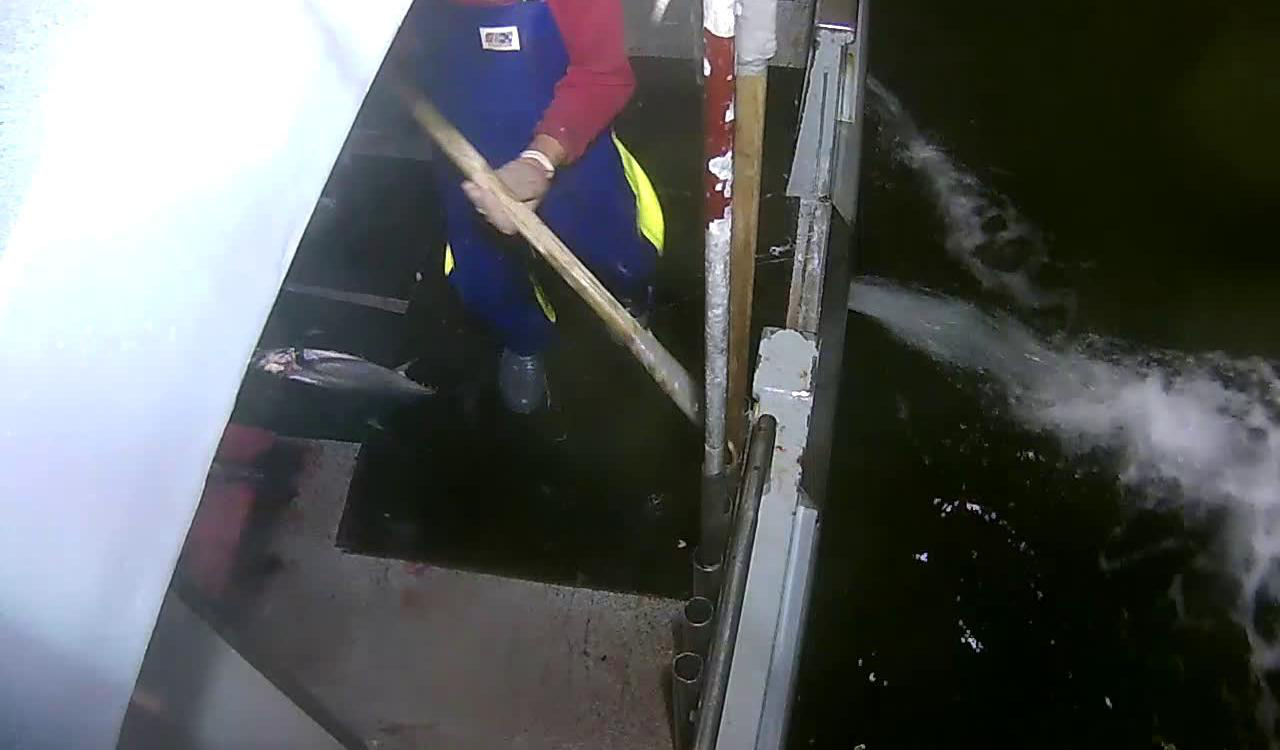

In [ ]:
Image.open(files[1])

### Annotations

In [ ]:
anno_files = os.listdir(anno_dir)
anno_files

['alb_labels.json',
 'bet_labels.json',
 'dol_labels.json',
 'lag_labels.json',
 'other_labels.json',
 'shark_labels.json',
 'yft_labels.json']

In [ ]:
filename = f'{anno_dir}/{anno_files[0]}'
print(open(filename, 'r').read())

[
    {
        "annotations": [
            {
                "class": "rect",
                "height": 151.06975503141317,
                "width": 383.68430384213445,
                "x": 547.1578480789353,
                "y": 193.3597426816281
            }
        ],
        "class": "image",
        "filename": "img_07917.jpg"
    },
    {
        "annotations": [
            {
                "class": "rect",
                "height": 65.00000000000023,
                "width": 166.00000000000063,
                "x": 469.00000000000165,
                "y": 448.0000000000016
            },
            {
                "class": "rect",
                "height": 143.0000000000005,
                "width": 98.00000000000036,
                "x": 92.00000000000033,
                "y": 495.00000000000176
            }
        ],
        "class": "image",
        "filename": "img_07915.jpg"
    },
    {
        "annotations": [
            {
                "class": "rect",
     

### Create validation data

In [ ]:
if not os.path.exists(valid_dir):
    create_validation_data(train_dir, valid_dir, split=0.2, ext='jpg')

### Fish Dataset

In [ ]:
class FishDataset(Dataset):
    def __init__(self, ds, bboxes, sz=299):
        """ Prepare fish dataset
        
        Inputs:
            root: the directory which contains all required data such as images, labels, etc.
            ds: torchvision ImageFolder dataset.
            bboxes: a dictionary containing the coordinates of the bounding box in each images
            transforms: required transformations on each image
        """
        self.imgs = ds.imgs
        self.classes = ds.classes
        self.bboxes = bboxes
        self.sz = sz
        self.tfms = transforms.Compose([
            transforms.Resize((sz, sz)),
            transforms.ToTensor(),
            transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
        ])
    
    def __getitem__(self, index):
        img, lbl = self.imgs[index]
        
        # get bounding box
        img_name = os.path.basename(img)
        if img_name in self.bboxes.keys():
            bbox = self.bboxes[img_name]
        else:
            bbox = {'class': 'rect', 'height': 0., 'width': 0., 'x': 0., 'y': 0.}
            
        # convert [h, w, x, y] to [r1, c1, r2, c2] format        
        bbox = bbox_to_r1c1r2c2(bbox)
        
        # read image and perform transformations
        image = Image.open(img).convert('RGB')
        w, h = image.size
        
        w_scale = sz / w
        h_scale = sz / h
        
        # transformations
        image = self.tfms(image)
        
        # normalize and scale bounding box
        bbox[0] = (bbox[0] / h) * h_scale
        bbox[1] = (bbox[1] / w) * w_scale
        bbox[2] = (bbox[2] / h) * h_scale
        bbox[3] = (bbox[3] / w) * w_scale
        
        # return image tensor, label tensor and bounding box tensor
        return image, lbl, torch.Tensor(bbox), (w, h)
    
    def __len__(self):
        return len(self.imgs)

### Training and Validation dataset

In [ ]:
# training data
train_data = datasets.ImageFolder(train_dir)
train_ds = FishDataset(train_data, bb_json, sz=sz)
train_dl = DataLoader(train_ds, batch_size=bs, shuffle=True)

# validation data
valid_data = datasets.ImageFolder(valid_dir)
valid_ds = FishDataset(valid_data, bb_json, sz=sz)
valid_dl = DataLoader(valid_ds, batch_size=bs, shuffle=False)

# sample data
sample_data = datasets.ImageFolder(sample_dir)
sample_ds = FishDataset(sample_data, bb_json, sz=sz)
sample_dl = DataLoader(sample_ds, batch_size=bs, shuffle=False)

### Visulaize data

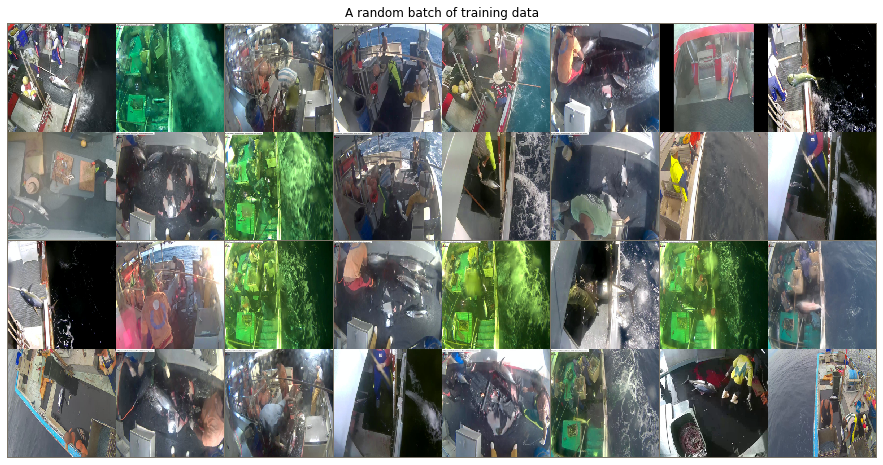

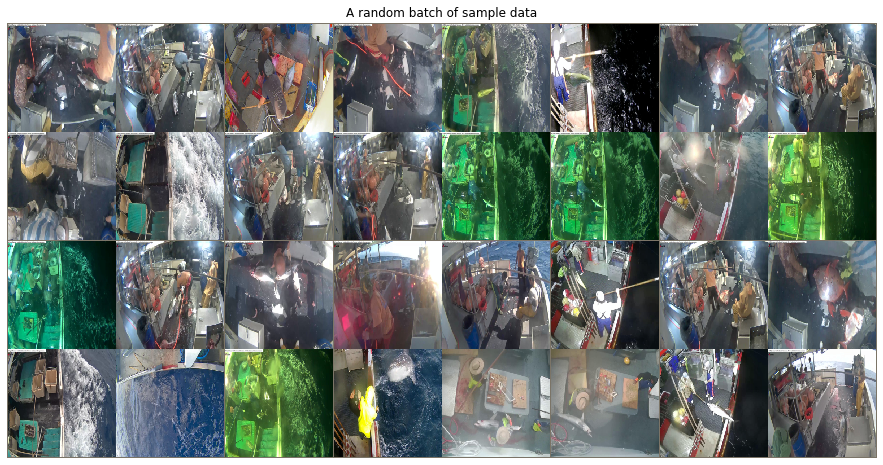

In [ ]:
dataiter = iter(train_dl)
imgs, lbls, bbs, sizes = next(dataiter)
img = torchvision.utils.make_grid(imgs, nrow=8)
plt.figure(figsize=(16, 8))
imshow(img, title='A random batch of training data')

#sample
dataiter = iter(sample_dl)
imgs, lbls, bbs, sizes = next(dataiter)
img = torchvision.utils.make_grid(imgs, nrow=8)
plt.figure(figsize=(16, 8))
imshow(img, title='A random batch of sample data')



torch.Size([3, 299, 299])
0 : TRAIN
[0.17753956 0.0297467  0.23494756 0.09106506]


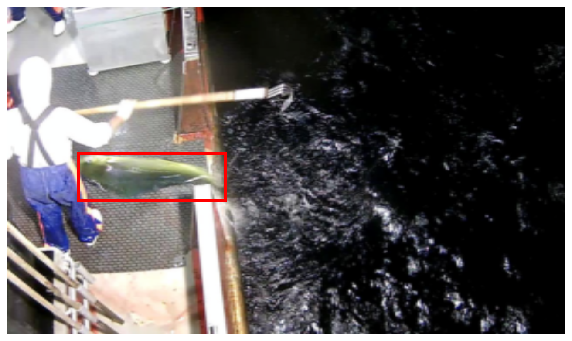

In [ ]:
# get one specific data from training data
img, lbl, bb, (w, h) = sample_ds[5]

# print size, label, and bounding box
print(img.size())
print(lbl, ':', sample_ds.classes[lbl])
print(bb.numpy())

# plot image and bounding box
plot_bbox(img, bb, w, h)

## Classification with Localization

<img src='https://github.com/muhamadzade/Deep_Learning_Week03/blob/master/imgs/localization.png?raw=1' width='90%'/>

### Model

In [ ]:
class ClassifierLocalizer(nn.Module):
    def __init__(self, model_name, num_classes=8):
        super(ClassifierLocalizer, self).__init__()
        self.num_classes = num_classes
        
        # create cnn model
        model = get_model(model_name, num_classes)
        
        # remove fc layers and add a new fc layer
        num_features = model.fc.in_features
        model.fc = nn.Linear(num_features, num_classes + 4) # classifier + localizer
        self.model = model
    
    def forward(self, x):
        x = self.model(x)                    # extract features from CNN
        scores = x[:, :self.num_classes]     # class scores
        coords = x[:, self.num_classes:]     # bb corners coordinates
        return scores, F.sigmoid(coords)     # sigmoid output is in [0, 1]

### Loss Function

Loss function has two parts:
- Cross Entropy Loss (for classification)
- Sum of Squared Errors (for regression)

In [ ]:
class LocalizationLoss(nn.Module):
    def __init__(self, num_classes=8):
        super(LocalizationLoss, self).__init__()
        self.ce_loss = nn.CrossEntropyLoss(size_average=False)
        self.mse_loss = nn.MSELoss(size_average=False)
        
    def forward(self, scores, locs, labels, bboxes):
        # Cross Entropy (for classification)
        loss_cls = self.ce_loss(scores, labels)
        
        # Sum of Squared errors (for corner points)
        loss_r1 = self.mse_loss(locs[:, 0], bboxes[:, 0]) / 2.0
        loss_c1 = self.mse_loss(locs[:, 1], bboxes[:, 1]) / 2.0
        loss_r2 = self.mse_loss(locs[:, 2], bboxes[:, 2]) / 2.0
        loss_c2 = self.mse_loss(locs[:, 3], bboxes[:, 3]) / 2.0
        
        return loss_cls, loss_r1 + loss_c1 + loss_r2 + loss_c2

In [ ]:
model = ClassifierLocalizer(model_name)
if use_gpu: model = model.cuda()
    
criterion = LocalizationLoss()
if use_gpu: criterion = criterion.cuda()
    
optimizer = optim.Adam(model.parameters(), lr=0.0001)
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=1, gamma=0.95)

C:\ProgramData\Anaconda3\lib\site-packages\torch\nn\_reduction.py:42: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))


In [ ]:
model = train_model(model, train_dl, valid_dl, criterion, optimizer, scheduler, num_epochs=1)

Epoch 1/1
----------
  train Loss: 32.42814 (21.39915 + 1.10290), Acc: 0.81238


C:\prg\deep\Project03\fisheries\utils.py:21: UserWarning: volatile was removed and now has no effect. Use `with torch.no_grad():` instead.
  return Variable(x, volatile=volatile)


  valid Loss: 9.05401 (7.65805 + 0.13960), Acc: 0.93775


### Predicting bounding boxes

In [ ]:
# load weights
model.load_state_dict(torch.load('models/resnet34-299-loc-epoch-9-acc-0.97483.pth'))

0 : ALB


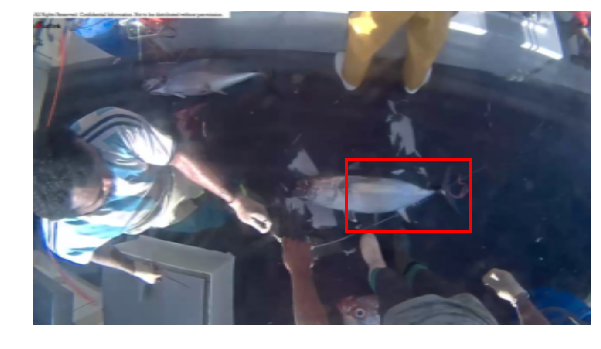

In [ ]:
valid_dl = DataLoader(valid_ds, batch_size=1, shuffle=True)
imgs, lbls, bbs, sizes = next(iter(valid_dl))
scores, locs = model(to_var(imgs, volatile=True))

scores = scores.data.cpu().numpy()
locs = locs.data.cpu().numpy()

pred_lbl = np.argmax(scores, axis=1)[0]
pred_bb = locs[0].tolist()

print(pred_lbl, ':', valid_ds.classes[pred_lbl])
w, h = sizes[0].numpy(), sizes[1].numpy()

plot_bbox(imgs[0], pred_bb, w, h)

## Other applications

### Key point detection

<img src='https://github.com/muhamadzade/Deep_Learning_Week03/blob/master/imgs/key_points.png?raw=1' width='80%'/>

### Pose estimation

<img src='https://github.com/muhamadzade/Deep_Learning_Week03/blob/master/imgs/pose.png?raw=1' width='80%'/>